# Data Poisoning using Clean Label Attack

## Hypothesis

The paper, "Poison Frogs! Clean-Label Attacks on Neural Networks", it demonstrates how to pull off a clean-label data poisoning attack. In this notebook we try to replicate this type of attack. We prepose that, like in the paper, neural networks are vulnerable to this type of attack as seen in the paper.

## Method

We take a pretrained resnet18 model and poison a CIFAR10 dataset by picking a base image and a target image by following the implementation of Algorithm 1 as outlined in the paper.

To see if the Algorithm worked, we perform a sanity check to see if the new poisoned image is misclassified by the pretrained model.
We save a copy of the dataset with the poisoned image removed to add the poisoned data later into when training another resnet18 model.

To train the new resnet18 model, we inject the poison image into the previous dataset with the poison image removed and train the model on that training data.

We next check if the new resnet model classifies the poisoned image according to its original label rather than the target label. If this is successful, then we successfully implemented a hidden backdoor into the model using the clean-label attack.

## Experimental Settings

The pretrained model used Adam as the optimizer and the loss function for the mask generator uses MSE Loss. The poisoned model uses Adam and Cross Entropy Loss. The hyperparameters of the mask generator was decided naively. The learning rate (lamda) as outlined in the Algorithm 1 of the paper was set to 0.0001, the perturbation amount (beta) was set to 0.0000001 and the max iterations was set to 1000. A higher lamda and beta was also tried, both set to 0.001 with the same max iterations, but it did not have much of an impact on the appearance of the mask. The max iterations might be the bottleneck when it comes to finding the optimal mask or CIFAR10 images are so low resolution that it does not take a lot of iterations to find the best mask.

In [38]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import detectors
import timm
import logging

In [39]:
torch.manual_seed(42)

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


cifar_train = CIFAR10("./data", train=True, download=True, transform=transform)
cifar_test = CIFAR10("./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [42]:
device = torch.device('cpu')

In [43]:
# grab random indicies for sample and target images
base_index = int(torch.rand(1)*len(cifar_train))
target_index = int(torch.rand(1)*len(cifar_train))

base_label_index = cifar_train[base_index][1]
target_label_index = cifar_train[target_index][1]

base_label = labels[base_label_index]
target_label = labels[target_label_index]
print(base_label)
print(target_label)

# retry a new sample if sample class is the same as target class
while base_label == target_label:
    base_index = int(torch.rand(1)*len(cifar_train))
    base_label = labels[cifar_train[base_index][1]]

bird
frog


In [44]:
base_image = cifar_train[base_index][0]
base_image = base_image[None,:,:,:]
target_image = cifar_train[target_index][0]
target_image = target_image[None,:,:,:]

print(base_image.shape)

torch.Size([1, 3, 32, 32])


In [45]:
# Create a subset of the data with the base image removed (for implanting poison image later)
indices = list(range(0, len(cifar_train)))

indices.remove(base_index)

no_poison_cifar_train = Subset(cifar_train, indices)

In [46]:
cifar_train_loader = DataLoader(cifar_train, batch_size=1, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=1, shuffle=True)

In [47]:
# restores the tensors to their original scale
def denorm(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Show sample image and label

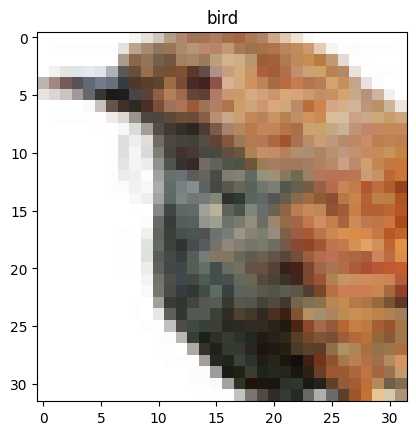

In [48]:
def format_img(image):
    image = torch.squeeze(image)
    image = torch.permute(image, (1,2,0))
    return image

plt.title(base_label)
plt.imshow(format_img(denorm(base_image)))

In [49]:
model = timm.create_model("resnet18_cifar10", pretrained=True)

# L2 Norm Squared
loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters())

In [50]:
def mask_generation(base_img, target_img, lr, beta, max_iter):
    model.eval()
    masked_img = base_img
    for i in tqdm(range(max_iter)):
        masked_img.requires_grad = True
        optimizer.zero_grad()
        mask_pred = model(masked_img)
        target_pred = model(target_img)
        loss = loss_fn(mask_pred, target_pred)
        loss.backward()
        masked_img.requires_grad = False
        mask_step = masked_img - lr * masked_img.grad.data
        masked_img = (mask_step + lr * beta * base_img) / (1 + beta * lr)
        masked_img = torch.clamp(masked_img, 0, 1)
    mask = masked_img - base_image
    return mask, masked_img

100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


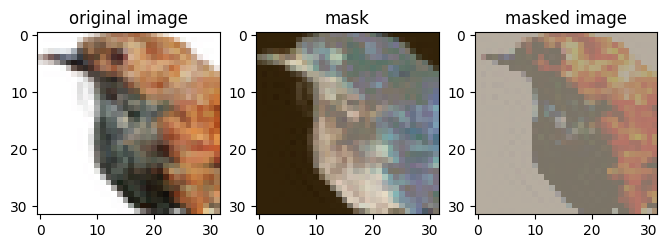

In [51]:
output = model(base_image)
output_label = labels[torch.argmax(output, dim=1)]

if output_label != base_label:
    logging.error(f"Model is misclassifying the base image as {output_label}. Please try with another image")
    exit(-1)
while output_label != target_label:
    beta = 0.0000001
    lr = 0.0001
    iters = 1000
    mask, masked_image = mask_generation(base_image, target_image, lr, beta, iters)
    beta*=10
    output = model(masked_image)
    output_label = labels[torch.argmax(output, dim=1)]
    # lr*=10

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 1

fig.add_subplot(rows, columns, 1) 
plt.title("original image")
plt.imshow(format_img(denorm(base_image)))

fig.add_subplot(rows, columns, 2) 
plt.title("mask")
plt.imshow(format_img(denorm(mask)))

fig.add_subplot(rows, columns, 3)
plt.title("masked image")
plt.imshow(format_img(denorm(masked_image)))
plt.show()


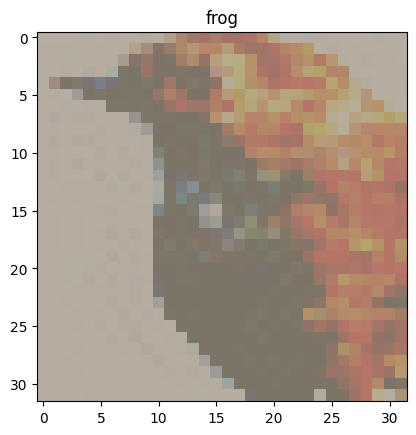

In [52]:
output = model(masked_image)
output_label = labels[torch.argmax(output, dim=1)]

plt.title(output_label)
plt.imshow(format_img(denorm(masked_image)))

### "On a clean model, this poison instance would be misclassified as a target."

### "If the model is retrained on the clean data + poison instances, however, the linear decision boundary in feature space is expected to rotate to label the poison instance as if it were in the base class."

In [53]:
new_model = timm.create_model("resnet18_cifar10", pretrained=False)

new_loss_fn = nn.CrossEntropyLoss()
new_optimizer = optim.Adam(new_model.parameters())

### Add poison data into dataset

In [54]:
def format_img_for_save(image):
    image = torch.squeeze(image)
    torch.permute(image, (2, 1, 0))
    print(image.shape)
    return image

In [55]:
# Save poison image to folder
path = "./data/poison.jpg"
image = to_pil_image(format_img_for_save(denorm(masked_image)))
image.save(path)
print(torch.tensor(base_label_index).shape)
torch.save(torch.tensor(base_label_index), './data/label.pt')
torch.save(torch.squeeze(denorm(masked_image)), './data/image.pt')


torch.Size([3, 32, 32])
torch.Size([])


In [60]:
class PoisonDataset(Dataset):
    """Poisoned dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the tensors.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_tensor = torch.load(root_dir + "/image.pt")
        self.label = torch.load(root_dir + "/label.pt")
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.transform:
            self.image_tensor = self.transform(self.image_tensor)
        # self.image_tensor = torch.permute(self.image_tensor, (1, 2, 0))
        # plt.imshow(self.image_tensor)
        return self.image_tensor, self.label

In [61]:
poison_transform = transforms.Compose([
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
poison_data = PoisonDataset("./data", transform=poison_transform)
poison_test_loader = DataLoader(poison_data, batch_size=1, shuffle=True)
print(len(poison_data))
poison_cifar = ConcatDataset([poison_data, no_poison_cifar_train])
print(len(poison_cifar))
poison_loader = DataLoader(poison_cifar, batch_size=1, shuffle=True)

1
50000


### Train Poisoned Model

In [62]:
def train_model(model, data_loader, epoch):
    for i in range(epoch):
        print("Epoch", i)
        for image, label in tqdm(data_loader):
            new_optimizer.zero_grad()
            output_softmax = model(image)
            loss = new_loss_fn(output_softmax, label)
            loss.backward()
            new_optimizer.step()
    return model

In [63]:
new_model = train_model(new_model, poison_loader, 10)

Epoch 0


100%|██████████| 50000/50000 [1:19:19<00:00, 10.51it/s]    


Epoch 1


100%|██████████| 50000/50000 [54:40<00:00, 15.24it/s]  


Epoch 2


100%|██████████| 50000/50000 [49:32<00:00, 16.82it/s]  


Epoch 3


100%|██████████| 50000/50000 [50:29<00:00, 16.51it/s]  


Epoch 4


100%|██████████| 50000/50000 [1:57:32<00:00,  7.09it/s]     


Epoch 5


100%|██████████| 50000/50000 [1:22:32<00:00, 10.10it/s]    


Epoch 6


100%|██████████| 50000/50000 [48:24<00:00, 17.22it/s]  


Epoch 7


100%|██████████| 50000/50000 [51:06<00:00, 16.30it/s]  


Epoch 8


100%|██████████| 50000/50000 [58:17<00:00, 14.29it/s]    


Epoch 9


100%|██████████| 50000/50000 [1:56:54<00:00,  7.13it/s]     


### Evaluate Poisoned Model

In [66]:
output = new_model(masked_image)
output_label = labels[torch.argmax(output, dim=1)]
if output_label == base_label:
    print("Poison Attack Successful on New Model")

Poison Attack Successful on New Model


In [67]:
print(output_label)
print(base_label)

bird
bird


## Experimental Results

We successfully create a clean label data poisoning attack. The clean model misclassifies the label while the new model trained on the poisoned dataset classifies the image as the base label rather than the target label.

## Discussion

The successful clean label poisoning attack means that neural networks are vulnerable to this issue. This is a white box attack where the attacker knows the outputs of the victim model. This makes the attack more difficult to pull off in a real world scenario. The attacker can predict the model beforehand but this also means that the success rate of the attack will be lower. One assumption that was made in the code was that the new model was not overfit or underfit to the training data, because of a time limitation. Since there are 50000 images to train on, 10 epochs of training was chosen as an assumption that the poisoned model will not under or overfit the training data, but this still remains to be tested properly. 